In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
"""
Denne cellen inneholder:
- En Q-learning-agent for FrozenLake
- Evalueringsfunksjoner for:
    * trent agent
    * tilfeldig policy
    * enkel heuristisk policy
- En funksjon for glidende gjennomsnitt (til plotting)
"""

class FrozenLakeAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float,
    ):
        """
        Enkel tabellbasert Q-learning-agent.
        
        - env: OpenAI/Gymnasium-miljø (FrozenLake-v1)
        - learning_rate: hvor mye vi oppdaterer Q-verdier hver gang
        - initial_epsilon: startnivå for utforsking (ε)
        - epsilon_decay: hvor raskt ε går ned
        - final_epsilon: minimumsverdi for ε
        - discount_factor: gamma (γ), hvor mye vi bryr oss om fremtidige belønninger
        """
        self.env = env
        self.q_table = np.zeros((env.observation_space.n, env.action_space.n))
        self.lr = learning_rate
        self.gamma = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        # Logger for å kunne se utviklingen under trening
        self.td_errors = []

    def choose_action(self, state: int) -> int:
        """
        Velger handling med epsilon-grådig strategi:
        - Med sannsynlighet ε: tilfeldig handling (utforsk)
        - Ellers: handling med høyest Q-verdi (utnytt)
        """
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        return int(np.argmax(self.q_table[state]))

    def update_q(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
    ):
        """
        Oppdaterer Q-tabellen med standard Q-learning:
        Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') - Q(s,a) ]
        """
        old_q = self.q_table[state, action]

        if terminated:
            best_next = 0.0
        else:
            best_next = np.max(self.q_table[next_state])

        target = reward + self.gamma * best_next
        new_q = (1 - self.lr) * old_q + self.lr * target

        self.q_table[state, action] = new_q
        self.td_errors.append(abs(new_q - old_q))

    def decay_epsilon(self):
        """
        Reduserer utforskingsgraden etter hver episode.
        """
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)


def evaluate_trained_agent(agent: FrozenLakeAgent, env: gym.Env, num_episodes: int = 1000):
    """
    Kjører miljøet flere episoder der agenten alltid velger 
    greedy handlinger ut fra Q-tabellen (ingen utforsking).
    Returnerer og printer suksessraten (andel episoder som når mål).
    """
    successes = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = int(np.argmax(agent.q_table[state]))
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done and reward > 0:
                successes += 1

    success_rate = successes / num_episodes
    print(f"Q-learning agent – suksessrate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate


def evaluate_random_baseline(env: gym.Env, num_episodes: int = 1000):
    """
    Baseline hvor agenten bare velger tilfeldige handlinger.
    Brukes for å vise hvor mye bedre Q-learning er enn ren flaks.
    """
    successes = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        steps = 0

        while not done and steps < 200:
            action = env.action_space.sample()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1

            if done and reward > 0:
                successes += 1

    success_rate = successes / num_episodes
    print(f"Tilfeldig policy – suksessrate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate


def evaluate_heuristic_baseline(env: gym.Env, num_episodes: int = 1000):
    """
    Veldig enkel heuristikk:
    - annenhver gang går vi ned og til høyre (1 = Down, 2 = Right).
    Dette tilsvarer en «naiv» planlagt rute uten å ta hensyn til slipp.
    """
    successes = 0

    for _ in range(num_episodes):
        state, _ = env.reset()
        done = False
        steps = 0

        while not done and steps < 200:
            action = 1 if steps % 2 == 0 else 2
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            steps += 1

            if done and reward > 0:
                successes += 1

    success_rate = successes / num_episodes
    print(f"Heuristisk policy – suksessrate: {success_rate:.3f} ({success_rate*100:.1f}%)")
    return success_rate


def moving_average(arr, window: int, mode: str = "valid"):
    """
    Glatter ut støyete data ved å ta glidende gjennomsnitt over 'window' steg.
    Brukes for å få penere treningskurver.
    """
    arr = np.array(arr).flatten()
    kernel = np.ones(window)
    return np.convolve(arr, kernel, mode=mode) / window


In [3]:
"""
Denne cellen samler:
- Felles miljøkonfig for FrozenLake med:
  * is_slippery=True (stokastiske overganger)
  * reward_schedule (goal, hole, frozen)
  * egen step_penalty som legges oppå reward
- Eget sett hyperparametre for 4x4 og 8x8
"""

COMMON_ENV_CONFIG = {
    "is_slippery": True,                  # simulert glatt gulv
    "success_rate": 1.0 / 3.0,            # sannsynlighet for «riktig» action i slippery-modus
    "reward_schedule": (1.0, 0.0, 0.0),   # (mål, hull, trygg is) – sparse reward
    "step_penalty": -0.002                # lite trekk per steg for å oppmuntre korte ruter
}

# 4x4 – liten tilstandplass, enklere problem
PARAMS_4X4 = {
    "EPISODES": 20_000,
    "learning_rate": 0.10,
    "discount_factor": 0.99,
    "initial_epsilon": 1.0,
    "final_epsilon": 0.05,
    # vil omtrent nå final_epsilon ved slutten av treningen
    "epsilon_decay": 0.99985,
}

# 8x8 – langt større og vanskeligere, krever flere episoder og mer forsiktig nedtrapping av epsilon
PARAMS_8X8 = {
    "EPISODES": 100_000,
    "learning_rate": 0.05,
    "discount_factor": 0.99,
    "initial_epsilon": 1.0,
    "final_epsilon": 0.10,
    "epsilon_decay": 0.999977,
}

def extract_agent_params(param_dict):
    """
    Henter kun de parameterne som trengs for å initialisere agenten.
    (Gjør det enklere å sende samme dict til flere funksjoner.)
    """
    keys = ["learning_rate", "discount_factor", "initial_epsilon", "epsilon_decay", "final_epsilon"]
    return {k: param_dict[k] for k in keys}


In [4]:
"""
Her defineres:
- visualize_grid: viser S/F/H/G i et heatmap
- run_experiment: 
    * lager miljø
    * trener agenten
    * plotter treningskurver
    * evaluerer vs random og heuristikk
"""

def visualize_grid(env, map_name: str):
    """
    Tegner opp FrozenLake-kartet der:
    S = start
    F = trygg is
    H = hull (fare)
    G = mål
    """
    desc = env.unwrapped.desc.astype(str)
    n_rows, n_cols = desc.shape

    colour_map = {"F": 0, "H": 1, "S": 2, "G": 3}
    grid = np.zeros((n_rows, n_cols))

    for r in range(n_rows):
        for c in range(n_cols):
            grid[r, c] = colour_map[desc[r, c]]

    plt.figure(figsize=(n_cols, n_rows))
    sns.heatmap(
        grid,
        annot=desc,
        fmt="",
        cmap=plt.cm.get_cmap("Blues", 4),
        cbar=False,
        linewidths=1,
        linecolor="black",
    )
    plt.title(f"FrozenLake {map_name} – kartlayout")
    plt.xticks(np.arange(n_cols) + 0.5, np.arange(n_cols))
    plt.yticks(np.arange(n_rows) + 0.5, np.arange(n_rows))
    plt.show()


def run_experiment(
    map_name: str,
    env_config: dict,
    train_params: dict,
    agent_params: dict | None = None
):
    """
    Kjører et komplett eksperiment for én kartstørrelse:
      1) Lager miljøet
      2) Visualiserer kartet
      3) Trener Q-learning-agenten
      4) Plotter læringskurver (reward, episodelengde, TD-error)
      5) Evaluerer mot random og heuristisk policy

    Returnerer suksessraten til den trente agenten.
    """
    print("\n" + "=" * 60)
    print(f"Starter eksperiment for kart: {map_name}")
    print("=" * 60)

    # Pakk ut reward-schedule og step-penalty
    goal_r, hole_r, frozen_r = env_config.get("reward_schedule", (1.0, 0.0, 0.0))
    step_penalty = env_config.get("step_penalty", -0.002)

    gym_kwargs = {
        "is_slippery": env_config["is_slippery"],
        "success_rate": env_config["success_rate"],
        "reward_schedule": (goal_r, hole_r, frozen_r),
    }

    env = gym.make("FrozenLake-v1", map_name=map_name, **gym_kwargs)

    # Hvis agent_params ikke er gitt eksplisitt, prøver vi å hente dem fra train_params
    if agent_params is None:
        agent_params = extract_agent_params(train_params)

    print(f"\nKartvisning ({map_name}):")
    visualize_grid(env, map_name)

    # Initialiser agent
    agent = FrozenLakeAgent(
        env=env,
        learning_rate=agent_params["learning_rate"],
        initial_epsilon=agent_params["initial_epsilon"],
        epsilon_decay=agent_params["epsilon_decay"],
        final_epsilon=agent_params["final_epsilon"],
        discount_factor=agent_params["discount_factor"],
    )

    num_episodes = int(train_params.get("EPISODES", 10_000))
    episode_rewards = []
    episode_lengths = []

    print(f"Trener i {num_episodes} episoder...\n")

    # Hvor ofte vi printer status (maks ~10 ganger)
    n_updates = min(10, max(1, num_episodes // 100))
    update_interval = max(1, num_episodes // n_updates)

    for ep in range(num_episodes):
        state, _ = env.reset()
        done = False
        ep_reward = 0.0
        ep_len = 0

        while not done:
            action = agent.choose_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # legger til liten kostnad per steg
            reward = reward + step_penalty

            agent.update_q(state, action, reward, terminated, next_state)

            ep_reward += reward
            ep_len += 1
            state = next_state

        agent.decay_epsilon()

        episode_rewards.append(ep_reward)
        episode_lengths.append(ep_len)

        if (ep + 1) % update_interval == 0 or ep == num_episodes - 1:
            window = min(1000, max(10, num_episodes // 20))
            window = min(window, len(episode_rewards))

            recent_rewards = episode_rewards[-window:]
            avg_reward = float(np.mean(recent_rewards)) if recent_rewards else 0.0
            success_rate_window = float(
                np.mean([1.0 if r > 0 else 0.0 for r in recent_rewards])
            ) if recent_rewards else 0.0

            print(
                f"Episode {ep+1}/{num_episodes} | "
                f"snitt-belønning (siste {window}) = {avg_reward:.3f} | "
                f"suksessrate≈{success_rate_window:.3f} | "
                f"ε={agent.epsilon:.4f}"
            )

    print("\nTrening ferdig!")

    # --- Plotting av treningskurver ---
    roll_window = min(500, max(1, num_episodes // 20))

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"Q-learning på FrozenLake {map_name}", fontsize=16)

    # Reward
    axes[0].set_title("Belønning per episode (glattet)")
    if len(episode_rewards) >= roll_window:
        rew_ma = moving_average(episode_rewards, roll_window, mode="valid")
        axes[0].plot(rew_ma)
    else:
        axes[0].plot(episode_rewards)
    axes[0].set_xlabel("Episode")
    axes[0].set_ylabel("Belønning")

    # Episodelengde
    axes[1].set_title("Episodelengde (glattet)")
    if len(episode_lengths) >= roll_window:
        len_ma = moving_average(episode_lengths, roll_window, mode="valid")
        axes[1].plot(len_ma)
    else:
        axes[1].plot(episode_lengths)
    axes[1].set_xlabel("Episode")
    axes[1].set_ylabel("Antall steg")

    # TD-error
    axes[2].set_title("Temporal Difference-feil (glattet)")
    if len(agent.td_errors) >= roll_window:
        td_ma = moving_average(agent.td_errors, roll_window, mode="same")
        axes[2].plot(td_ma)
    else:
        axes[2].plot(agent.td_errors)
    axes[2].set_xlabel("Oppdatering")
    axes[2].set_ylabel("|ΔQ|")

    plt.tight_layout()
    plt.show()

    # --- Sluttevaluering og baseline-sammenligning ---
    print("\nENDLIG EVALUERING")
    print("=" * 60)
    final_success = evaluate_trained_agent(agent, env, num_episodes=1000)

    print("\nBASELINE-POLICIES")
    print("=" * 60)
    random_success = evaluate_random_baseline(env, num_episodes=1000)
    heur_success = evaluate_heuristic_baseline(env, num_episodes=1000)

    print("\nOPPSUMMERING")
    print("=" * 60)
    print(f"Q-learning-agent: {final_success:.3f} ({final_success*100:.1f}%)")
    print(f"Tilfeldig policy: {random_success:.3f} ({random_success*100:.1f}%)")
    print(f"Heuristikk     : {heur_success:.3f} ({heur_success*100:.1f}%)")

    if random_success > 0:
        print(f"Forbedring vs tilfeldig: {final_success / random_success:.1f}×")
    if heur_success > 0:
        print(f"Forbedring vs heuristikk: {final_success / heur_success:.1f}×")

    env.close()
    return final_success



--- Eksperiment: 4x4-kart ---

Starter eksperiment for kart: 4x4

Kartvisning (4x4):


C:\Users\Lara\AppData\Local\Temp\ipykernel_21652\832676917.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("Blues", 4),


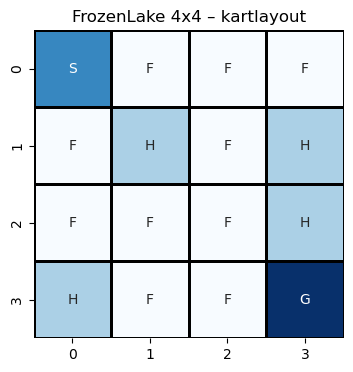

Trener i 20000 episoder...

Episode 2000/20000 | snitt-belønning (siste 1000) = 0.014 | suksessrate≈0.032 | ε=0.7408
Episode 4000/20000 | snitt-belønning (siste 1000) = 0.026 | suksessrate≈0.049 | ε=0.5488
Episode 6000/20000 | snitt-belønning (siste 1000) = 0.062 | suksessrate≈0.092 | ε=0.4065
Episode 8000/20000 | snitt-belønning (siste 1000) = 0.115 | suksessrate≈0.151 | ε=0.3012
Episode 10000/20000 | snitt-belønning (siste 1000) = 0.137 | suksessrate≈0.178 | ε=0.2231
Episode 12000/20000 | snitt-belønning (siste 1000) = 0.197 | suksessrate≈0.244 | ε=0.1653
Episode 14000/20000 | snitt-belønning (siste 1000) = 0.239 | suksessrate≈0.294 | ε=0.1224
Episode 16000/20000 | snitt-belønning (siste 1000) = 0.340 | suksessrate≈0.405 | ε=0.0907
Episode 18000/20000 | snitt-belønning (siste 1000) = 0.375 | suksessrate≈0.446 | ε=0.0672
Episode 20000/20000 | snitt-belønning (siste 1000) = 0.435 | suksessrate≈0.507 | ε=0.0500

Trening ferdig!


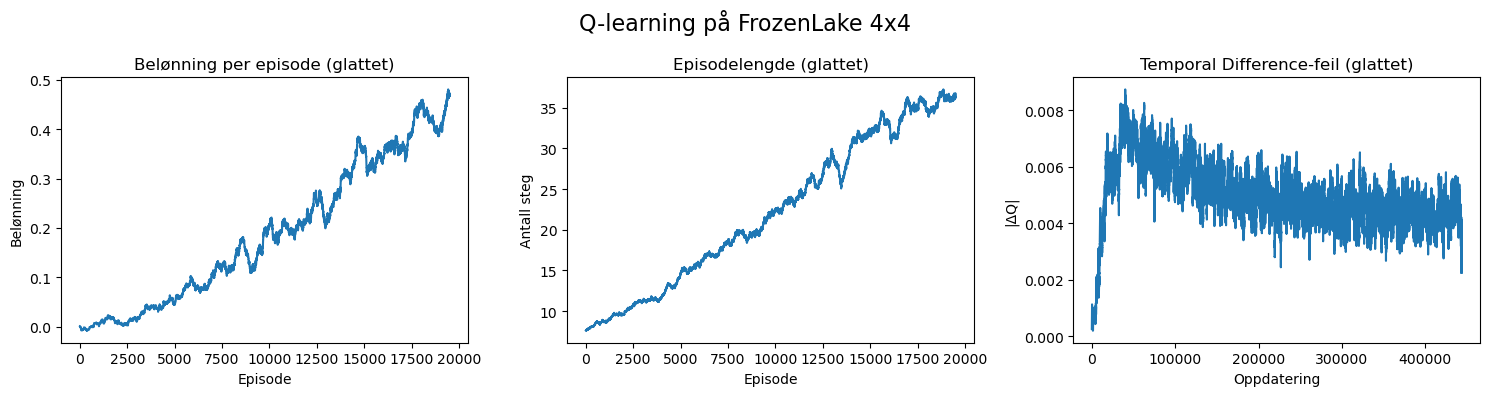


ENDLIG EVALUERING
Q-learning agent – suksessrate: 0.756 (75.6%)

BASELINE-POLICIES
Tilfeldig policy – suksessrate: 0.012 (1.2%)
Heuristisk policy – suksessrate: 0.050 (5.0%)

OPPSUMMERING
Q-learning-agent: 0.756 (75.6%)
Tilfeldig policy: 0.012 (1.2%)
Heuristikk     : 0.050 (5.0%)
Forbedring vs tilfeldig: 63.0×
Forbedring vs heuristikk: 15.1×

--- Eksperiment: 8x8-kart ---

Starter eksperiment for kart: 8x8

Kartvisning (8x8):


C:\Users\Lara\AppData\Local\Temp\ipykernel_21652\832676917.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("Blues", 4),


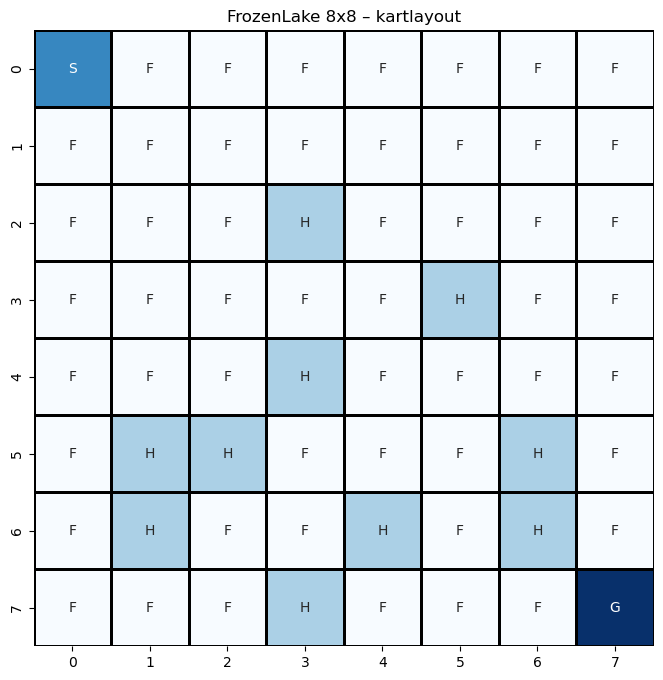

Trener i 100000 episoder...

Episode 10000/100000 | snitt-belønning (siste 1000) = -0.048 | suksessrate≈0.001 | ε=0.7945
Episode 20000/100000 | snitt-belønning (siste 1000) = -0.052 | suksessrate≈0.022 | ε=0.6313
Episode 30000/100000 | snitt-belønning (siste 1000) = -0.053 | suksessrate≈0.044 | ε=0.5016
Episode 40000/100000 | snitt-belønning (siste 1000) = -0.030 | suksessrate≈0.074 | ε=0.3985
Episode 50000/100000 | snitt-belønning (siste 1000) = -0.002 | suksessrate≈0.111 | ε=0.3166
Episode 60000/100000 | snitt-belønning (siste 1000) = 0.058 | suksessrate≈0.175 | ε=0.2516
Episode 70000/100000 | snitt-belønning (siste 1000) = 0.082 | suksessrate≈0.206 | ε=0.1999
Episode 80000/100000 | snitt-belønning (siste 1000) = 0.126 | suksessrate≈0.258 | ε=0.1588
Episode 90000/100000 | snitt-belønning (siste 1000) = 0.173 | suksessrate≈0.304 | ε=0.1262
Episode 100000/100000 | snitt-belønning (siste 1000) = 0.210 | suksessrate≈0.347 | ε=0.1003

Trening ferdig!


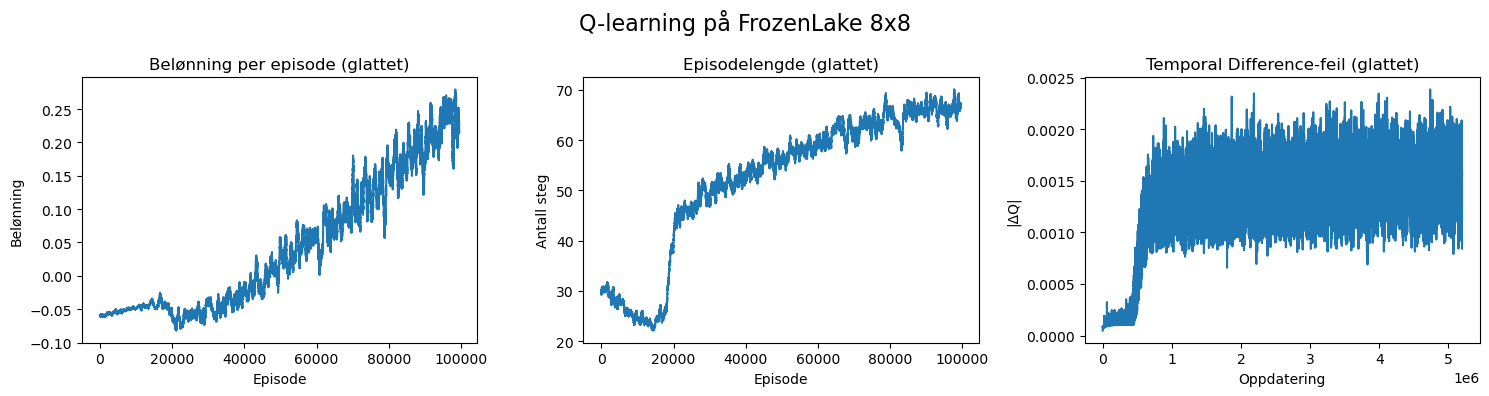


ENDLIG EVALUERING
Q-learning agent – suksessrate: 0.628 (62.8%)

BASELINE-POLICIES
Tilfeldig policy – suksessrate: 0.000 (0.0%)
Heuristisk policy – suksessrate: 0.020 (2.0%)

OPPSUMMERING
Q-learning-agent: 0.628 (62.8%)
Tilfeldig policy: 0.000 (0.0%)
Heuristikk     : 0.020 (2.0%)
Forbedring vs heuristikk: 31.4×

=== SLUTTRAPPORT ===
Endelig suksessrate 4x4: 0.756
Endelig suksessrate 8x8: 0.628


In [5]:
"""
Siste steg:
- Kjør eksperiment på 4x4-kartet
- Kjør eksperiment på 8x8-kartet
- Print sluttresultater for begge
"""

print("\n--- Eksperiment: 4x4-kart ---")
agent_cfg_4x4 = extract_agent_params(PARAMS_4X4)
final_4x4 = run_experiment(
    map_name="4x4",
    env_config=COMMON_ENV_CONFIG,
    train_params=PARAMS_4X4,
    agent_params=agent_cfg_4x4,
)

print("\n--- Eksperiment: 8x8-kart ---")
agent_cfg_8x8 = extract_agent_params(PARAMS_8X8)
final_8x8 = run_experiment(
    map_name="8x8",
    env_config=COMMON_ENV_CONFIG,
    train_params=PARAMS_8X8,
    agent_params=agent_cfg_8x8,
)

print("\n=== SLUTTRAPPORT ===")
print(f"Endelig suksessrate 4x4: {final_4x4:.3f}")
print(f"Endelig suksessrate 8x8: {final_8x8:.3f}")
